<a href="https://colab.research.google.com/github/katrina906/CS6120-Summarization-Project/blob/main/compare_extractive_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# only using False versions of metrics because always choose the same models for both and thus all results are the same
  # except baseline fmeasure

In [11]:
%%capture 
!pip install rouge-score
!pip install import-ipynb
!pip install fasttext
!pip install compress-fasttext
!pip install gensim==3.8.3

In [3]:
import os
import pandas as pd
import numpy as np
import pickle
import string
import re
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from collections import Counter, OrderedDict
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
import networkx as nx
from rouge_score import rouge_scorer
import gensim
import fasttext
from gensim.models import FastText
import compress_fasttext
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords  
import matplotlib.pyplot as plt
import numpy as np
import import_ipynb
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))  

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# load in functions from extract_summarization notebook
%cd "drive/MyDrive/Colab Notebooks"
import extractive_summarization
%cd ..

/content/drive/MyDrive/Colab Notebooks
importing Jupyter notebook from extractive_summarization.ipynb
/content/drive/MyDrive


### Load best models (one per algorithm, per metric)

In [6]:
model_dict = {}
eval_dict = {}
config_dict = {}
for model in ['lsa', 'textrank', 'baseline']:
  with open('/content/drive/MyDrive/data/trained_model_' + model + '.pkl', 'rb') as f:
    load = pickle.load(f)
    eval_dict[model] = load[1]
    model_dict[model] = load[2]
    config_dict[model] = load[3]

## Calculate P-Value with Paired Bootstrap Test

For best configuration for each evaluation metric, compare the 3 model types: which model is the best and what is the p-value?
1. Calculate difference in stat performance (recall etc.)
2. Generate N bootstrapped samples of data 
3. Train on bootstrapped data
4. Calculate difference in performance on bootstraped data
5. Count percent of replicate diffs that are >= 2 * original diff = p-value  
  - Null hypothesis is that there is no difference and the true effect size is original diff (data happens to be biased towards one model)
  - If see a lot of replicated diffs >= 2 * original diff, then null is true and there is no difference between the models

In [6]:
def paired_bootstrap(evals, models, configs, pvalue_dict, model1, model2, metric, save_every_cnt = 10, filename = '', restart = True):
  embeddings = extractive_summarization.load_embeddings()

  # which model is better and by how much
  if evals[model1][metric]['mean'] > evals[model2][metric]['mean']:
    better_model = model1
    other_model = model2
  else:
    better_model = model2
    other_model = model1
  diff =  evals[better_model][metric]['mean'] - evals[other_model][metric]['mean']
  print(better_model, diff)

  # allow start partway through 50 bootstrap samples 
  if not restart:
    with open('/content/drive/MyDrive/data/' + filename + '_' + model1 + '_' + model2 + '_' + str(metric) + '.pkl','rb') as f:
      results_so_far = pickle.load(f) 
    gt_diff = results_so_far[0]
    lt_diff = results_so_far[1]
    start = results_so_far[2]
  else:
    gt_diff = 0
    lt_diff = 0
    start = 0

  for i in range(start+1, 51):
    print('BS', i)
    # generate bootstrap samples 
    bs_sample = {}
    bs_sample[model1] = models[model1][metric].sample(n = len(models[model1][metric]), replace = True)
    bs_sample[model2] = models[model2][metric].sample(n = len(models[model2][metric]), replace = True)

    # retrain both models on bootstrap samples with the current config
    bs_results = {}
    for m in [model1, model2]:
      config = tuple(config_dict[m][metric].strip('(').strip(')').replace("'", "").split(', '))
      if 'baseline' in config:
        tfidf, feature_array = extractive_summarization.corpus_tfidf(bs_sample[m])
      else:
        tfidf = ''
        feature_array = ''
      eval_results, _ = extractive_summarization.train_config_loop(bs_sample[m], tfidf, feature_array, embeddings, stop_words, 
                                                                    [config], eval_only = True)
      bs_results[m] = eval_results[str(config)][metric]['mean']
      
    # find difference in relevant stat
    diff_bs = bs_results[better_model] - bs_results[other_model]
    print(diff_bs)
    if diff_bs >= 2*diff:
      gt_diff += 1
    else:
      lt_diff += 1

    # save bootstrap samples every save_every_cnt in case of connection issue, timeout etc.
    if ((i % save_every_cnt) == 0 or (i == 50)) and filename != '':
      with open('/content/drive/MyDrive/data/' + filename + '_' + model1 + '_' + model2 + '_' + str(metric) + '.pkl', 'wb') as f:
        pickle.dump([gt_diff, lt_diff, i], f)
        print('saving!', i)
    
  # calculate p value
  pvalue = gt_diff / (gt_diff + lt_diff)
  pvalue_dict[metric] = (better_model, pvalue)

  return pvalue_dict

In [8]:
with open('/content/drive/MyDrive/data/pvalue_' + models[0] + '_' + models[1] + '.pkl', 'rb') as f:
    pvalue_dict = pickle.load(f)

In [ ]:
for models in [('baseline', 'lsa')]: #, ('baseline', 'textrank'), ('lsa', 'textrank')]: 
  if os.path.exists('/content/drive/MyDrive/data/pvalue_' + models[0] + '_' + models[1] + '.pkl'):
    # allow loading from pvalue dict with only some of the metrics
    with open('/content/drive/MyDrive/data/pvalue_' + models[0] + '_' + models[1] + '.pkl', 'rb') as f:
      pvalue_dict = pickle.load(f)
  else:
    pvalue_dict = {}
  for metric in ('fmeasure', False), ('precision', False), ('recall', False):
    if str(metric) not in pvalue_dict.keys():
      pvalue_dict = paired_bootstrap(eval_dict, model_dict, config_dict, pvalue_dict, models[0], models[1], metric,
                                     filename = 'bootstrap_loop', restart = False)
    with open('/content/drive/MyDrive/data/pvalue_' + models[0] + '_' + models[1] + '.pkl', 'wb') as f:
      pickle.dump(pvalue_dict, f)

In [ ]:
config_dict
# lsa always no normalization, stemming, bow, all 3 grams
# textrank always stem, bow, cosine similarity 
# never embeddings used

{'lsa': {('fmeasure',
   False): "('lsa', 'nostop', 'stem', 'bow', 'binary', 'no_normalization', 'all', 'num_sentences')",
  ('fmeasure',
   True): "('lsa', 'nostop', 'stem', 'bow', 'binary', 'no_normalization', 'all', 'num_sentences')",
  ('precision',
   False): "('lsa', 'stopwords', 'stem', 'bow', 'counts', 'no_normalization', 'trigram', 'num_words_lt')",
  ('precision',
   True): "('lsa', 'stopwords', 'stem', 'bow', 'binary', 'no_normalization', 'all', 'num_words_lt')",
  ('recall',
   False): "('lsa', 'nostop', 'stem', 'bow', 'binary', 'no_normalization', 'all', 'num_sentences')",
  ('recall',
   True): "('lsa', 'nostop', 'stem', 'bow', 'binary', 'no_normalization', 'all', 'num_sentences')"},
 'textrank': {('fmeasure',
   False): "('textrank', 'stopwords', 'stem', 'bow', 'binary', 'no_normalization', 'bigram', 'cosine', 'num_words_gt')",
  ('fmeasure',
   True): "('textrank', 'stopwords', 'stem', 'bow', 'binary', 'no_normalization', 'bigram', 'cosine', 'num_words_gt')",
  ('precis

### Compare algorithm performance

__Best Configs for Respective Best Metric__

Text(0.5, 1.0, 'TextRank Uniformally Outperforms other Models')

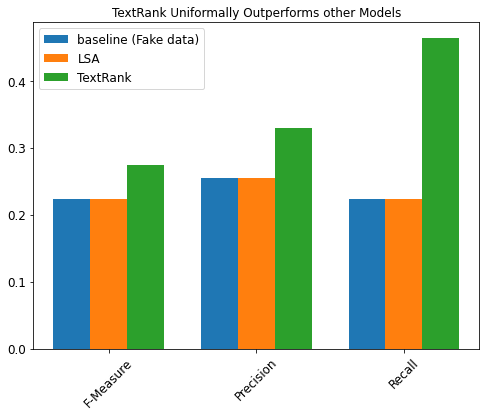

In [ ]:
# side by side metric values for each metric across models (bar plot)
fig, ax = plt.subplots(figsize=(8,6))
mean_lst = {'lsa':[], 'textrank':[], 'baseline':[]}
for metric in [('fmeasure', False), ('precision', False), ('recall', False)]:
  for model in ['lsa', 'textrank']:
    mean_lst[model].append(eval_dict[model][metric]['mean'])
x = np.arange(len(mean_lst))
w = 0.25
ax.bar(x, mean_lst['lsa'], width = w, label = 'baseline (Fake data)')
ax.bar(x + w, mean_lst['lsa'], width = w, label = 'LSA')
ax.bar(x + 2*w, mean_lst['textrank'], width = w, label = 'TextRank')
ax.legend(fontsize = 12)
ax.set_xticks(x + w)
ax.set_xticklabels(['F-Measure', 'Precision', 'Recall'], rotation = 45)
ax.tick_params(axis='both', which='major', labelsize = 12)
ax.set_title('TextRank Uniformally Outperforms other Models', size = 12)

# TODO mark if significant? annotate?
# note fmeasure and recall models the same for LSA
# note these are the best models for each - not comparing precision vs recall for the same model

__Each of Best 9 models for all 3 metrics__

In [ ]:
for model in ['textrank', 'lsa']:
  for metric in [('fmeasure', False), ('precision', False), ('recall', False)]:
    model_dict[model][metric]['precision'] = model_dict[model][metric].rouge.map(lambda row: row['rouge1'].precision)
    model_dict[model][metric]['recall'] = model_dict[model][metric].rouge.map(lambda row: row['rouge1'].recall)
    model_dict[model][metric]['fmeasure'] = model_dict[model][metric].rouge.map(lambda row: row['rouge1'].fmeasure)

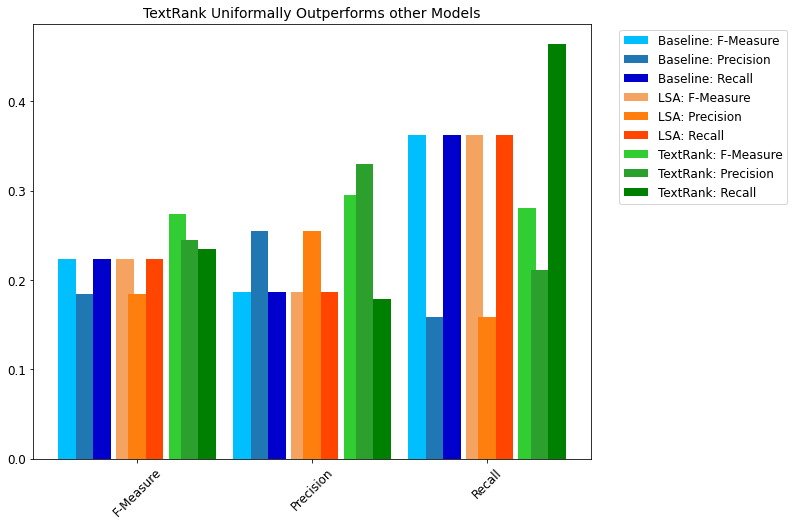

In [ ]:
# side by side metric values for each metric across models (bar plot)
fig, ax = plt.subplots(figsize=(10,8))
mean_lst = {}
for model in ['lsa', 'textrank', 'baseline']:
  for stat in ['fmeasure', 'precision', 'recall']:
    mean_lst[model + '-' + stat] = []
for model in ['lsa', 'textrank']:
  for metric in [('fmeasure', False), ('precision', False), ('recall', False)]:
    for stat in ['fmeasure', 'precision', 'recall']:
      mean_lst[model + '-' + metric[0]].append(model_dict[model][metric][stat].mean())

x = np.arange(len(mean_lst['lsa-fmeasure']))
w = 0.1
ax.bar(x, mean_lst['lsa-fmeasure'] , width = w, label = 'Baseline: F-Measure', color = 'deepskyblue')
ax.bar(x+w, mean_lst['lsa-precision'], width = w, label = 'Baseline: Precision', color = 'C0')
ax.bar(x+2*w, mean_lst['lsa-recall'] , width = w, label = 'Baseline: Recall', color = 'mediumblue')

ax.bar(x+3*w+0.03, mean_lst['lsa-fmeasure'] , width = w, label = 'LSA: F-Measure', color = 'sandybrown')
ax.bar(x+4*w, mean_lst['lsa-precision'], width = w, label = 'LSA: Precision', color = 'C1')
ax.bar(x+5*w, mean_lst['lsa-recall'] , width = w, label = 'LSA: Recall', color = 'orangered')

ax.bar(x+6*w+0.03, mean_lst['textrank-fmeasure'] , width = w, label = 'TextRank: F-Measure', color = 'limegreen')
ax.bar(x+7*w, mean_lst['textrank-precision'], width = w, label = 'TextRank: Precision', color = 'C2')
ax.bar(x+8*w, mean_lst['textrank-recall'] , width = w, label = 'TextRank: Recall', color = 'green')

ax.set_xticks(x + 4*w)
ax.set_xticklabels(['F-Measure', 'Precision', 'Recall'], rotation = 45)
ax.tick_params(axis='both', which='major', labelsize = 12)
ax.set_title('TextRank Uniformally Outperforms other Models', size = 14)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", fontsize = 12)

# TODO mark if significant? annotate?
# note fmeasure and recall models the same for LSA
# Fmesaure better for all textrank models. recall does significantly better than others and its equivalents do almost as well as other models. 
  # could do better in precision, but recall more important

## Compare Predicted Summaries across Algorithms and Metrics


In [ ]:
# length of summary by metric within model
summary_len_metric = {'lsa':{}, 'textrank':{}}
for model in ['lsa', 'textrank']:
  for metric in [('fmeasure', False), ('precision', False), ('recall', False)]:
    df = model_dict[model][metric]
    df['summary_num_words'] = df.predicted_summary.map(lambda row: len(''.join(row).split(' ')))
    df['summary_num_sentences'] = df.predicted_summary.map(lambda row: len(row))
    summary_len_metric[model][metric] = [df.summary_num_sentences.mean(), df.summary_num_words.mean()]

Text(0.5, 1.0, 'TextRank')

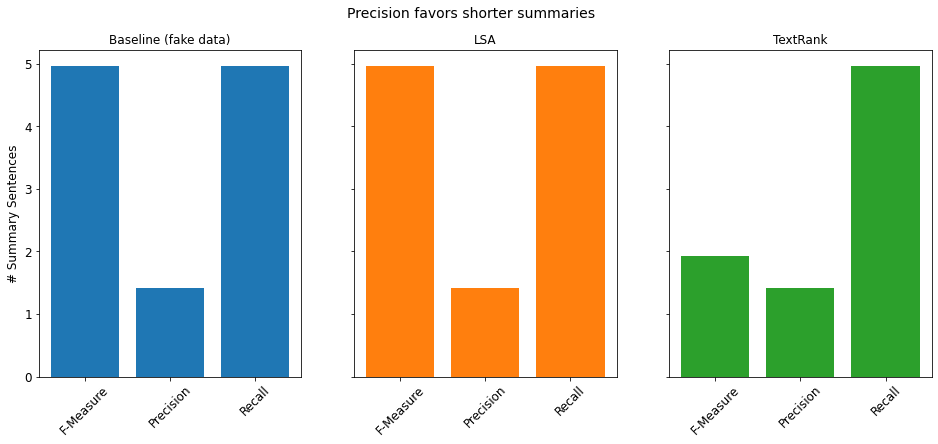

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6), sharey=True)
barlst = axs[0].bar(['F-Measure', 'Precision', 'Recall'], [i[0] for i in list(summary_len_metric['lsa'].values())], color = 'C0')
barlst = axs[1].bar(['F-Measure', 'Precision', 'Recall'], [i[0] for i in list(summary_len_metric['lsa'].values())], color = 'C1')
barlst = axs[2].bar(['F-Measure', 'Precision', 'Recall'], [i[0] for i in list(summary_len_metric['textrank'].values())], color = 'C2')

for i in range(3):
  axs[i].set_xticklabels(['F-Measure', 'Precision', 'Recall'], rotation = 45)
  axs[i].tick_params(axis='both', which='major', labelsize = 12)
fig.suptitle('Precision favors shorter summaries', size = 14)
axs[0].set_ylabel('# Summary Sentences', size = 12)
axs[0].set_title('Baseline (fake data)', size = 12)
axs[1].set_title("LSA", size = 12)
axs[2].set_title('TextRank', size = 12)

# all 3 models get very similar sized summaries
# precision favors shorter summaries. maximizing overlap with predicted summary, so extra non relevant info hurts 

In [ ]:
# TODO stats on types of summaries generated by each model and for best of each metric. Ex: recall best summaries longer than precision summaries? etc.
# problems with models include that sentences can appear in odd orders. BUT our human content creator can rearrange - care more about getting the right info in front of them.
  # thus prefer longer summaries? care more about recall than precision?